# Langevin Integrator Check

The `toy_dynamics` subpackage provides an integrator called `LangevinBAOABIntegrator`, which is based on [a paper by Leimkuhler and Matthews](http://dx.doi.org/10.1093/amrx/abs010). This notebook uses the `toy_dynamics` package to check that the integrator gives the correct position and velocity distribution for a harmonic oscillator.

Note that this particular test does not make use of the trajectory storage tools. It is mainly to show how to use the `toy_dynamics` subpackage, and has little connection to the main package. The trajectory generated here is extremely long, so in this case we choose not to store it. For an example using `toy_dynamics` with the storage tools, see ???(to be added later)???.

### Imports

In [1]:
import openpathsampling.engines.toy as toys
import openpathsampling as paths
import numpy as np

### Set up the simulation

This the potential energy surface is $V(x,y) = \frac{A[0]}{2}m[0] \omega[0]^2 (x-x_0[0])^2 + \frac{A[1]}{2}m[1] \omega[1]^2 (y-x_0[1])^2$

In [2]:
my_pes = toys.HarmonicOscillator(A=[1.0, 1.0], omega=[2.0, 1.0], x0=[0.0, 0.0])

topology=toys.Topology(n_spatial=2, masses=[1.0,2.0], pes=my_pes)


my_integ = toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.5, gamma=1.0)

sim = toys.Engine(options={'integ' : my_integ, 'n_steps_per_frame' : 50}, topology=topology)

template = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]), 
                         velocities=np.array([[0.1, 0.0]]), 
                         engine=sim)


In [3]:
nframes = 250000

Set the initial conditions for the system, and initialize the sample storage.

In [4]:
sim.current_snapshot = template

In [5]:
x1 = []
x2 = []
v1 = []
v2 = []

### Run the simulation

This might take a while...

In [6]:
for i in range(nframes):
    # generate the next frame (which is sim.n_steps_per_frame timesteps)
    snap = sim.generate_next_frame()
    # sample the information desired to check distributions
    pos = snap.coordinates[0]
    vel = snap.velocities[0]
    x1.append(pos[0])
    x2.append(pos[1])
    v1.append(vel[0])
    v2.append(vel[1])

### Run analysis calculation

Build the 1D histograms we'll use:

In [7]:
nbins = 50
rrange = (-2.5, 2.5)
rrangex1 = ((min(x1)), (max(x1)))
rrangev1 = ((min(v1)), (max(v1)))
rrangex2 = (min(x2), max(x2))
rrangev2 = (min(v2), max(v2))
dens = True
(x1hist, binsx1) = np.histogram(x1, bins=nbins, range=rrange, density=dens)
(x2hist, binsx2) = np.histogram(x2, bins=nbins, range=rrange, density=dens)
(v1hist, binsv1) = np.histogram(v1, bins=nbins, range=rrange, density=dens)
(v2hist, binsv2) = np.histogram(v2, bins=nbins, range=rrange, density=dens)

Build the 2D histograms:

In [8]:
(hist1, xb1, yb1) = np.histogram2d(x1, v1, [nbins/2, nbins/2], [rrangex1, rrangev1])
(hist2, xb2, yb2) = np.histogram2d(x2, v2, [nbins/2, nbins/2], [rrangex2, rrangev2])

Run the analysis of the kinetic energy:

In [9]:
instantaneous_ke = []
cumulative_ke_1 = []
cumulative_ke_2 = []
tot_ke_1 = 0.0
tot_ke_2 = 0.0
for v in zip(v1, v2):
    local_ke_1 = 0.5*sim.mass[0]*v[0]*v[0]
    local_ke_2 = 0.5*sim.mass[1]*v[1]*v[1]
    instantaneous_ke.append(local_ke_1+local_ke_2)
    tot_ke_1 += local_ke_1
    tot_ke_2 += local_ke_2
    cumulative_ke_1.append(tot_ke_1 / (len(cumulative_ke_1)+1))
    cumulative_ke_2.append(tot_ke_2 / (len(cumulative_ke_2)+1))

### Plot our results

Imports for the plots we'll use, as well as some parameter adjustment.

In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend_handler import HandlerLine2D
import numpy as np

pylab.rcParams['figure.figsize'] = 12, 4
matplotlib.rcParams.update({'font.size' : 18})

Now we plot the distributions of the positions and velocities. These should match the exact Gaussians they're paired with.

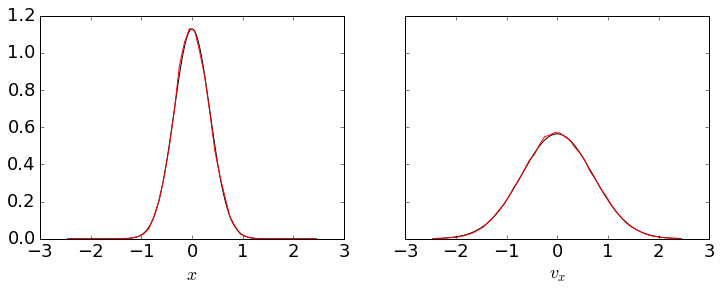

In [11]:
# Boltzmann info as a in exp(-ax^2)
boltzmann_vel1 = 0.5*sim.integ.beta*sim.mass[0]
boltzmann_pos1 = 0.5*sim.integ.beta*sim.mass[0]*sim.pes.omega[0]**2
plotbinsx1 = [0.5*(binsx1[i]+binsx1[i+1]) for i in range(len(binsx1)-1)]
plotbinsx2 = [0.5*(binsx2[i]+binsx2[i+1]) for i in range(len(binsx2)-1)]
plotbinsv1 = [0.5*(binsv1[i]+binsv1[i+1]) for i in range(len(binsv1)-1)]
plotbinsv2 = [0.5*(binsv2[i]+binsv2[i+1]) for i in range(len(binsv2)-1)]
lx1 = np.linspace(min(plotbinsx1), max(plotbinsx1), 5*len(plotbinsx1))
lx2 = np.linspace(min(plotbinsx2), max(plotbinsx2), 5*len(plotbinsx2))
lv1 = np.linspace(min(plotbinsv1), max(plotbinsv1), 5*len(plotbinsv1))
lv2 = np.linspace(min(plotbinsv2), max(plotbinsv2), 5*len(plotbinsv2))
f, (ax1, av1) = plt.subplots(1,2, sharey=True)
px1 = ax1.plot(lx1, np.sqrt(boltzmann_pos1/np.pi)*np.exp(-boltzmann_pos1*lx1**2), 'k-', plotbinsx1, x1hist, 'r-')
px1 = ax1.set_xlabel('$x$')
pv1 = av1.plot(lv1, np.sqrt(boltzmann_vel1/np.pi)*np.exp(-boltzmann_vel1*lv1**2), 'k-', plotbinsv1, v1hist, 'r-')
pv1 = av1.set_xlabel('$v_x$')

In the above, you should see that the exact answer (black line) matches up reasonably well with the calculated results (red line). You might notice that the left graph, for  position, doesn't match quite as well as the right graph, for velocities. This is as expected: the integrator should impose the correct velocity distribution, but sampling space correctly requires more time to converge.

The plots above check the $x$ degree of freedom; the plots below do the same for $y$.

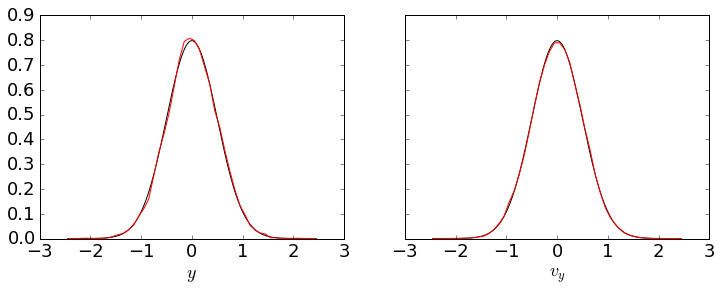

In [12]:
boltzmann_vel2 = 0.5*sim.integ.beta*sim.mass[1]
boltzmann_pos2 = 0.5*sim.integ.beta*sim.mass[1]*sim.pes.omega[1]**2
f, (ax2, av2) = plt.subplots(1,2, sharey=True)
px2 = ax2.plot(lx2, np.sqrt(boltzmann_pos2/np.pi)*np.exp(-boltzmann_pos2*lx2**2), 'k-', plotbinsx2, x2hist, 'r-')
px2 = ax2.set_xlabel('$y$')
pv2 = av2.plot(lv2, np.sqrt(boltzmann_vel2/np.pi)*np.exp(-boltzmann_vel2*lv2**2), 'k-', plotbinsv2, v2hist, 'r-')
pv2 = av2.set_xlabel('$v_y$')

Next we plot the 2D histograms for each degree of freedom. These should be reasonably circular.

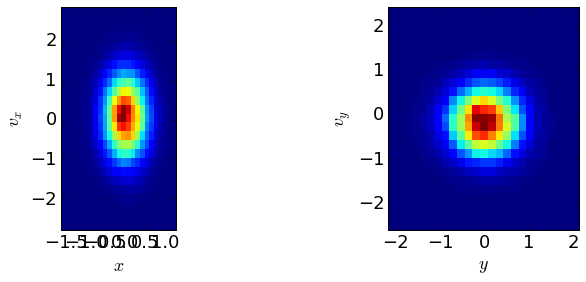

In [13]:
f, (ah1, ah2) = plt.subplots(1,2)
ah1.set_xlabel('$x$')
ah1.set_ylabel('$v_x$')
ah2.set_xlabel('$y$')
ah2.set_ylabel('$v_y$')
hist1plt = ah1.imshow(hist1.T, extent=[xb1[0],xb1[-1],yb1[0],yb1[-1]], interpolation='nearest')
hist2plt = ah2.imshow(hist2.T, extent=[xb2[0],xb2[-1],yb2[0],yb2[-1]], interpolation='nearest')

The two plots above should look reasonably similar to each other, although the axes will depend on your choice of $m$ and $\omega$.

The final plot is of the kinetic energy information:

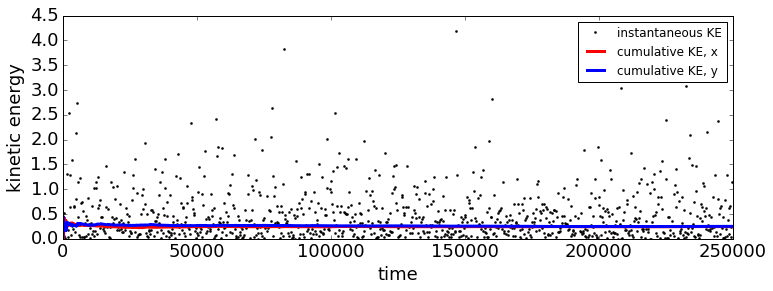

In [14]:
timeseries = [sim.integ.dt*sim.n_steps_per_frame*i for i in range(nframes)]
inst_KE, = plt.plot(timeseries[::nframes/1000], instantaneous_ke[::nframes/1000], 'ko', label='instantaneous KE',markersize=2)

ke_1 = plt.plot(timeseries, cumulative_ke_1, 'r-', label='cumulative KE, x', linewidth=3)
ke_2 = plt.plot(timeseries, cumulative_ke_2, 'b-', label='cumulative KE, y', linewidth=3)
leg = plt.legend(prop={'size' : 12}, handler_map={inst_KE: HandlerLine2D(numpoints=1)})
plt.xlabel('time');
plt.ylabel('kinetic energy');

The cumulative kinetic energy for each degree of freedom should converge to the same value, which should be half the temperature (since we have $k_\text{B}=1$). The instantaneous values of the kinetic energy should suggest a longer tail.